# Sentinel-2 Data Analytics

This notebook loads `.zarr` Sentinel-2 Level-2A datasets and computes various statistics, correlations, and visualizations.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as ski
import json

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from shapely.geometry import shape
from skimage.transform import resize
from matplotlib.animation import FuncAnimation, PillowWriter
from datetime import datetime

plt.style.use('seaborn-v0_8')

## 1. Parameters

In [22]:
# Directory containing .zarr files
DATA_DIR = "/home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target"

# Bands to use for analytics
BANDS = ["b02", "b03", "b04", "b8a", "b11", "b12"]  # Blue, Green, Red, NIR, NIR narrow, SWIR1, SWIR2

# zarr files
zarr_files = glob.glob(os.path.join(DATA_DIR, "*.zarr"))

## 2. Helper Functions

In [12]:
# Sentinel-2 SCL codes for clouds/snow
CLOUD_CODES = {8, 9, 10, 11}

def open_s2_zarr(zarr_path):
    """Open Sentinel-2 .zarr as a DataTree."""
    return xr.open_datatree(zarr_path, engine="zarr", mask_and_scale=False)

def compute_cloud_fraction(dt, ref_band_name="b04"):
    """Compute cloud fraction from SCL mask."""
    refl = dt.measurements.reflectance.r10m
    # Find reference band
    ref_band = None
    for cand in (ref_band_name, ref_band_name.lower(), "B04", "b04"):
        if cand in refl:
            ref_band = refl[cand]
            break
    if ref_band is None:
        raise ValueError("No reference band found in reflectance.")

    scl = dt.conditions.mask.l2a_classification.r20m["scl"]
    scl_10m = scl.interp_like(ref_band, method="nearest")

    cloud_mask = np.isin(scl_10m.values, list(CLOUD_CODES))
    return cloud_mask.sum() / cloud_mask.size

def compute_band_stats(dt, bands, res):
    """Compute mean, std, min, max for given bands."""
    stats = {}
    for b in bands:
        if b.lower() in dt.measurements.reflectance[res]:
            band_data = dt.measurements.reflectance[res][b.lower()].values
        else:
            continue
        stats[f"{b}_mean"] = np.nanmean(band_data)
        stats[f"{b}_std"] = np.nanstd(band_data)
        stats[f"{b}_min"] = np.nanmin(band_data)
        stats[f"{b}_max"] = np.nanmax(band_data)
    return stats


def compute_water_stats(dt, bands, res="r20m"):
    """
    Compute mean, std, min, max for water pixels of given bands.

    Parameters:
        dt : xarray-like dataset
        bands : list of band names (strings)
        res : resolution key in dt.measurements.reflectance

    Returns:
        dict : statistics per band for water pixels
    """
    # Extract the SCL and create water mask
    scl = dt["conditions/mask/l2a_classification/r20m/scl"].squeeze().values
    water_mask = (scl == 6)

    stats = {}

    for b in bands:
        band_key = b.lower()
        if band_key in dt.measurements.reflectance[res]:
            band_data = dt.measurements.reflectance[res][band_key].values
            # Select water pixels
            water_data = band_data[water_mask]
            # Compute statistics
            stats[f"{b}_mean"] = np.nanmean(water_data)
            stats[f"{b}_std"] = np.nanstd(water_data)
            stats[f"{b}_min"] = np.nanmin(water_data)
            stats[f"{b}_max"] = np.nanmax(water_data)
        else:
            # If band not present, fill with NaNs
            stats[f"{b}_mean"] = np.nan
            stats[f"{b}_std"] = np.nan
            stats[f"{b}_min"] = np.nan
            stats[f"{b}_max"] = np.nan

    amei = compute_amei(dt)
    ndwi = compute_ndwi(dt)
    stats["amei_mean"] = np.nanmean(amei[water_mask])
    stats["ndwi_mean"] = np.nanmean(ndwi[water_mask])

    return stats

def compute_land_water_fraction(zarr_path):
    """
    Computes land/water pixel fractions from Sentinel-2 L2A classification.
    """
    try:
        dt = xr.open_datatree(zarr_path, engine="zarr", mask_and_scale=False)
        scl = dt["conditions/mask/l2a_classification/r20m/scl"].squeeze().values

        valid_mask = ~np.isnan(scl) & (scl != 0) & (scl != 255)
        total_valid = np.sum(valid_mask)

        water_pixels = np.sum(scl == 6)
        other_pixels = total_valid - water_pixels

        water_fraction = water_pixels / total_valid if total_valid > 0 else np.nan
        other_fraction = other_pixels / total_valid if total_valid > 0 else np.nan

        # Extract tile name from filename
        filename = os.path.basename(zarr_path)
        tile_name = filename.split("_")[5]  # e.g. T32TQQ

        return {
            "file": filename,
            "tile": tile_name,
            "water_fraction": water_fraction,
            "other_fraction": other_fraction,
            "total_pixels": total_valid
        }

    except Exception as e:
        print(f"Error processing {zarr_path}: {e}")
        return None


def get_rgb_from_zarr(ds, mask_water=False):
    # Extract RGB bands and scale to [0, 1]
    rgb = np.dstack([
        ds['measurements/reflectance/r20m/b04'].values.astype(np.float32) / 10000.0,  # Red
        ds['measurements/reflectance/r20m/b03'].values.astype(np.float32) / 10000.0,  # Green
        ds['measurements/reflectance/r20m/b02'].values.astype(np.float32) / 10000.0   # Blue
    ])

    # Water mask from SCL
    scl = ds["conditions/mask/l2a_classification/r20m/scl"].squeeze().values
    water_mask = (scl == 6)

    # Percentile stretch
    if mask_water == True:
        # Mask non-water pixels
        p2, p98 = np.nanpercentile(rgb, (2, 98))
        rgb[~water_mask] = 0.0
        rgb[water_mask] = np.clip((rgb[water_mask] - p2) / (p98 - p2), 0, 1)
    else:
        p2, p98 = np.nanpercentile(rgb, (2, 98))
        rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)
    return rgb

def compute_amei(ds, eps=1e-6):
    red   = ds["measurements/reflectance/r20m/b04"].values.astype(np.float32)
    nir   = ds["measurements/reflectance/r20m/b8a"].values.astype(np.float32)
    green = ds["measurements/reflectance/r20m/b03"].values.astype(np.float32)
    swir  = ds["measurements/reflectance/r20m/b11"].values.astype(np.float32)  # "B11" or "B12"

    # AMEI = (2*red + nir - 2*swir) / (green + 0.25*swir)
    denom = green + 0.25 * swir
    amei  = (2*red + nir - 2*swir) / (denom + eps)  # eps avoids divide-by-zero

    return amei

def compute_ndwi(ds, eps=1e-6):
    nir   = ds["measurements/reflectance/r20m/b8a"].values.astype(np.float32)
    green = ds["measurements/reflectance/r20m/b03"].values.astype(np.float32)

    # AMEI = (green - nir) / (green + nir)
    ndwi  = (green - nir) / (green + nir + eps)  # eps avoids divide-by-zero

    return ndwi


def resample_nn(arr, target_shape):
    return resize(
        arr,
        target_shape,
        order=0,  # nearest neighbor for categorical (SCL) or NN upsampling
        preserve_range=True,
        anti_aliasing=False
    ).astype(arr.dtype)


def resample_bilinear(arr, target_shape):
    return resize(
        arr,
        target_shape,
        order=1,  # bilinear for continuous reflectance
        preserve_range=True,
        anti_aliasing=False
    ).astype(arr.dtype)

## 3. Process All Scenes

In [ ]:
# Process all files
stats = []
for zf in zarr_files:
    res = compute_land_water_fraction(zf)
    if res:
        stats.append(res)

df_stats = pd.DataFrame(stats)

# Aggregate per tile
tile_summary = df_stats.groupby("tile")[["water_fraction", "other_fraction"]].mean().reset_index()

print("\nPer-tile average water/other fractions:")
print(tile_summary)

/tmp/ipykernel_320607/2104986677.py:6: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  dt = xr.open_datatree(zarr_path, engine="zarr", mask_and_scale=False)



Per-tile average water/other fractions:
     tile  water_fraction  other_fraction
0  T32TQQ        0.423312        0.576688
1  T32TQR        0.263306        0.736694
2  T33TUK        0.785625        0.214375
3  T33TUL        0.502361        0.497639


In [6]:
all_stats = []

for zf in zarr_files:
    try:
        dt = open_s2_zarr(zf)
        scene_stats = {"file": os.path.basename(zf)}
        scene_stats["cloud_fraction"] = compute_cloud_fraction(dt)
        scene_stats.update(compute_band_stats(dt, BANDS))
        all_stats.append(scene_stats)
    except Exception as e:
        print(f"Error processing {zf}: {e}")

df_stats = pd.DataFrame(all_stats)
df_stats

,file,cloud_fraction
0,S2B_MSIL2A_20240728T095549_N0511_R122_T32TQQ_2...,0.001443
1,S2A_MSIL2A_20240723T100031_N0511_R122_T32TQR_2...,0.205462
2,S2B_MSIL2A_20240728T095549_N0511_R122_T32TQR_2...,0.005111
3,S2B_MSIL2A_20240721T100559_N0510_R022_T32TQR_2...,0.078004
4,S2A_MSIL2A_20240716T100601_N0510_R022_T32TQQ_2...,0.008970
5,S2A_MSIL2A_20240726T100601_N0511_R022_T32TQQ_2...,0.003582
6,S2B_MSIL2A_20240718T095549_N0510_R122_T32TQQ_2...,0.005368
7,S2A_MSIL2A_20240726T100601_N0511_R022_T32TQR_2...,0.134681
8,S2A_MSIL2A_20240716T100601_N0510_R022_T32TQR_2...,0.010308
9,S2B_MSIL2A_20240721T100559_N0510_R022_T32TQQ_2...,0.010041


In [ ]:
# Resample single bands to another resolution

# upsample B11 (20 m) to 10 m
b11_20 = dt["measurements/reflectance/r20m/b11"].values # resample band 11 (swir, 20m)
shape_10 = dt["measurements/reflectance/r10m/b02"].shape # to same resolution/shape of another band (band 2, 10m)
b11_10 = resample_bilinear(b11_20, shape_10)

## 4. Correlation Matrix Between Bands

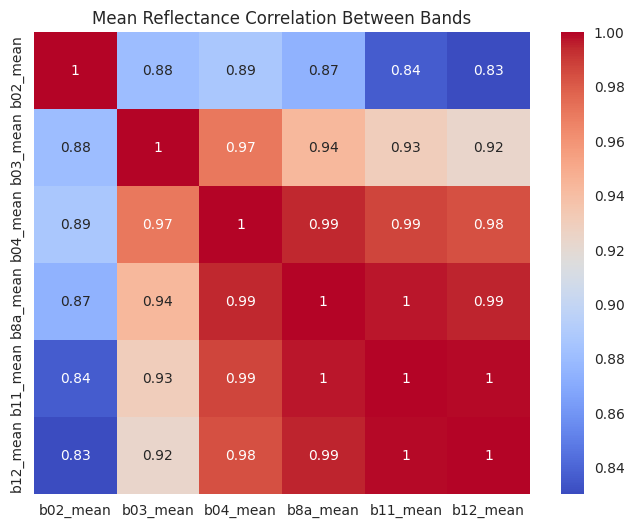

In [14]:
corr = df_stats[[f"{b}_mean" for b in BANDS]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Mean Reflectance Correlation Between Bands")
plt.show()

## 5. t-SNE on Band Statistics

### All pixels

In [8]:
all_stats = []
cloud_frac = []
amei = []
ndwi = []

for file in zarr_files:
    dt = open_s2_zarr(file)
    res = compute_band_stats(dt, BANDS, 'r20m')
    cloud = compute_cloud_fraction(dt)
    amei_idx = compute_amei(dt)
    ndwi_idx = compute_ndwi(dt)
    amei_mean = np.nanmean(amei_idx)
    ndwi_mean = np.nanmean(ndwi_idx)
    all_stats.append(res)
    cloud_frac.append(cloud)
    amei.append(amei_mean)
    ndwi.append(ndwi_mean)


df_stats = pd.DataFrame(all_stats)
df_stats['cloud_fraction'] = cloud_frac
df_stats['amei'] = amei
df_stats['ndwi'] = ndwi

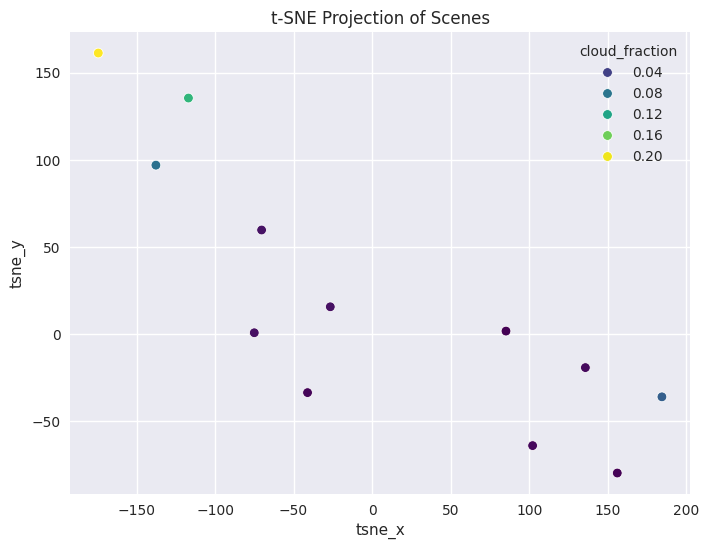

In [9]:
X = df_stats[[f"{b}_mean" for b in BANDS]].fillna(0)
X['amei'] = df_stats['amei']
X['ndwi'] = df_stats['ndwi']
X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_coords = tsne.fit_transform(X_scaled)

df_stats['tsne_x'] = tsne_coords[:,0]
df_stats['tsne_y'] = tsne_coords[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_stats, x='tsne_x', y='tsne_y', hue='cloud_fraction', palette='viridis')
plt.title("t-SNE Projection of Scenes")
plt.show()

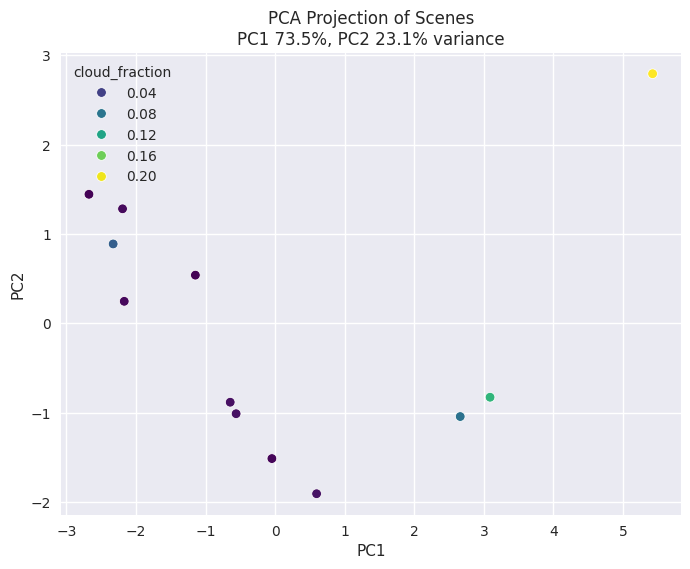

In [10]:
# Run PCA
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X_scaled)

# Save coords in df_stats
df_stats['pca_x'] = pca_coords[:, 0]
df_stats['pca_y'] = pca_coords[:, 1]

# Variance explained
explained_var = pca.explained_variance_ratio_ * 100

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_stats,
    x='pca_x', y='pca_y',
    hue='cloud_fraction', palette='viridis'
)
plt.title(f"PCA Projection of Scenes\nPC1 {explained_var[0]:.1f}%, PC2 {explained_var[1]:.1f}% variance")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [11]:
# PCA loadings (components)
loadings = pca.components_

for i, comp in enumerate(loadings):
    print(f"\nPC{i+1} ({explained_var[i]:.1f}% variance):")
    for feature, weight in zip(X.columns, comp):
        print(f"  {feature:10s} {weight:.3f}")


PC1 (73.5% variance):
  b02_mean   0.368
  b03_mean   0.390
  b04_mean   0.396
  b8a_mean   0.352
  b11_mean   0.377
  b12_mean   0.408
  amei       0.247
  ndwi       -0.248

PC2 (23.1% variance):
  b02_mean   0.322
  b03_mean   0.225
  b04_mean   0.172
  b8a_mean   -0.353
  b11_mean   -0.296
  b12_mean   -0.068
  amei       0.527
  ndwi       0.567


### Water mask

In [13]:
all_stats = []
cloud_frac = []

for file in zarr_files:
    dt = open_s2_zarr(file)
    res = compute_water_stats(dt, BANDS, 'r20m')
    cloud = compute_cloud_fraction(dt)
    all_stats.append(res)
    cloud_frac.append(cloud)


df_stats = pd.DataFrame(all_stats)
df_stats['cloud_fraction'] = cloud_frac

In [16]:
df_stats.head()

,b02_mean,b02_std,b02_min,b02_max,b03_mean,b03_std,b03_min,b03_max,b04_mean,b04_std,...,b11_std,b11_min,b11_max,b12_mean,b12_std,b12_min,b12_max,amei_mean,ndwi_mean,cloud_fraction
0,0.037122,0.007319,0.0093,0.5949,0.037155,0.014074,0.0111,0.6232,0.016510,0.011608,...,0.008880,-0.0072,0.6602,0.003857,0.006525,-0.0031,0.6048,0.816427,0.639405,0.001443
1,0.042444,0.020722,-0.0020,0.4905,0.036464,0.024283,-0.0014,0.5665,0.021646,0.020499,...,0.021834,-0.0009,0.6855,0.011598,0.021235,-0.0012,0.5410,0.880713,0.488230,0.205462
2,0.032720,0.009466,-0.0999,0.5791,0.028927,0.016605,-0.0477,0.6074,0.012225,0.013892,...,0.012607,-0.0044,0.6323,0.003712,0.009198,-0.0037,0.5416,0.665216,0.755337,0.005111
3,0.040960,0.014884,0.0062,0.5625,0.039062,0.022415,0.0100,0.5904,0.025300,0.017698,...,0.013599,-0.0121,0.5737,0.016462,0.011787,-0.0044,0.5297,0.796175,0.341591,0.078004
4,0.034812,0.014178,-0.0006,0.6103,0.041678,0.019695,0.0064,0.6332,0.023577,0.018407,...,0.016823,-0.0071,0.5715,0.011831,0.015127,-0.0038,0.5875,0.774143,0.546536,0.008970


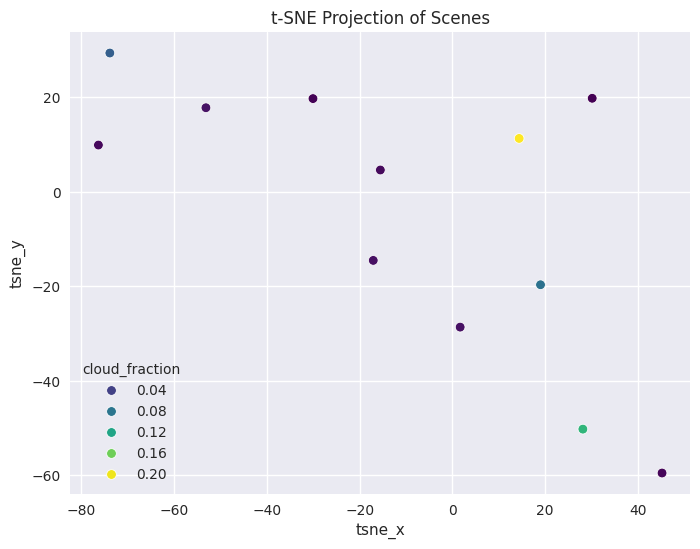

In [23]:
BANDS.extend(['amei', 'ndwi'])
X = df_stats[[f"{b}_mean" for b in BANDS]].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_coords = tsne.fit_transform(X_scaled)

df_stats['tsne_x'] = tsne_coords[:,0]
df_stats['tsne_y'] = tsne_coords[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_stats, x='tsne_x', y='tsne_y', hue='cloud_fraction', palette='viridis')
plt.title("t-SNE Projection of Scenes")
plt.show()

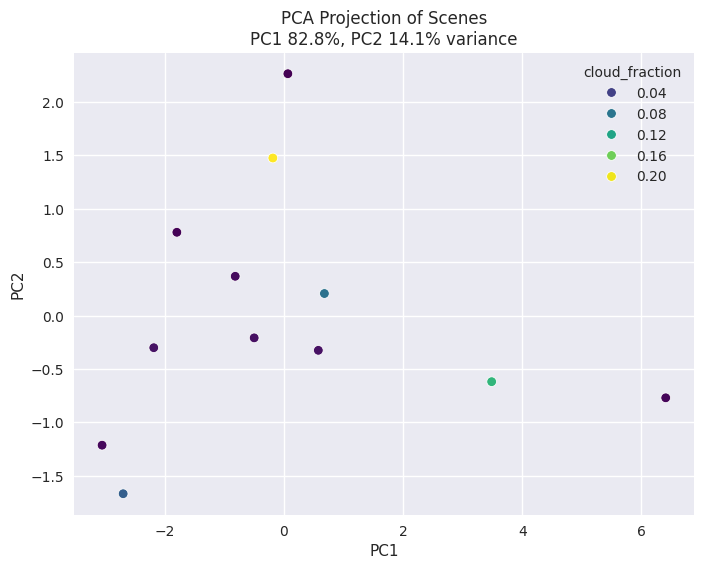

In [24]:
# Run PCA
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X_scaled)

# Save coords in df_stats
df_stats['pca_x'] = pca_coords[:, 0]
df_stats['pca_y'] = pca_coords[:, 1]

# Variance explained
explained_var = pca.explained_variance_ratio_ * 100

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_stats,
    x='pca_x', y='pca_y',
    hue='cloud_fraction', palette='viridis'
)
plt.title(f"PCA Projection of Scenes\nPC1 {explained_var[0]:.1f}%, PC2 {explained_var[1]:.1f}% variance")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [25]:
# PCA loadings (components)
loadings = pca.components_

for i, comp in enumerate(loadings):
    print(f"\nPC{i+1} ({explained_var[i]:.1f}% variance):")
    for feature, weight in zip(X.columns, comp):
        print(f"  {feature:10s} {weight:.3f}")


PC1 (82.8% variance):
  b02_mean   0.359
  b03_mean   0.372
  b04_mean   0.386
  b8a_mean   0.385
  b11_mean   0.380
  b12_mean   0.379
  amei_mean  0.106
  ndwi_mean  -0.370

PC2 (14.1% variance):
  b02_mean   0.288
  b03_mean   -0.038
  b04_mean   -0.079
  b8a_mean   -0.118
  b11_mean   -0.190
  b12_mean   -0.193
  amei_mean  0.902
  ndwi_mean  -0.098


## 6. Example RGB Composite

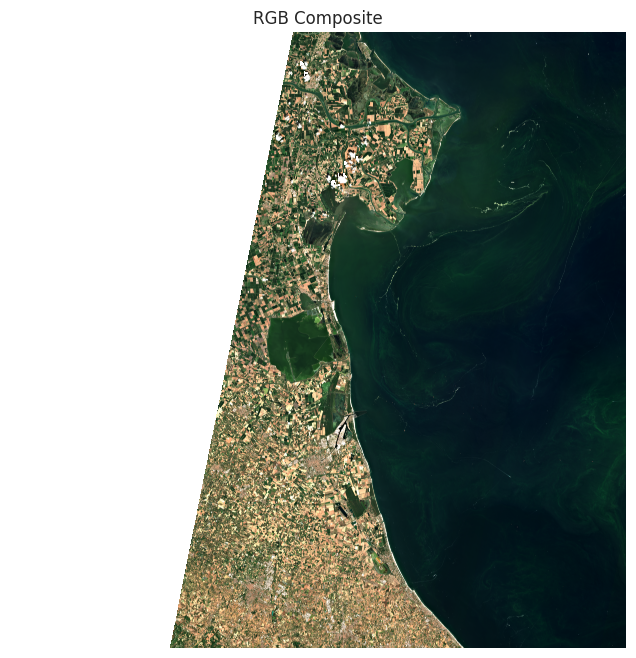

In [84]:
example_file = zarr_files[0]
ds = open_s2_zarr(example_file)

rgb = np.dstack([
    ds['measurements/reflectance/r10m/b04'].values.astype(np.float32) / 10000.0,
    ds['measurements/reflectance/r10m/b03'].values.astype(np.float32) / 10000.0,
    ds['measurements/reflectance/r10m/b02'].values.astype(np.float32) / 10000.0
])

# Simple percentile stretching
p2, p98 = np.nanpercentile(rgb, (2, 98))
rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)

plt.figure(figsize=(10,8))
plt.imshow(rgb)
plt.title("RGB Composite")
plt.axis('off')
plt.show()

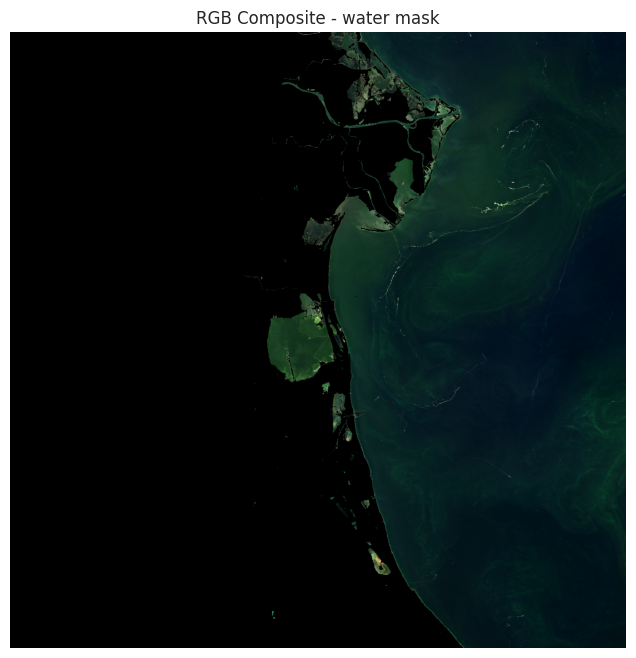

In [96]:
example_file = zarr_files[0]
ds = open_s2_zarr(example_file)
rgb_water = get_rgb_from_zarr(ds, mask_water=True)

plt.figure(figsize=(10,8))
plt.imshow(rgb_water)
plt.title("RGB Composite - water mask")
plt.axis('off')
plt.show()

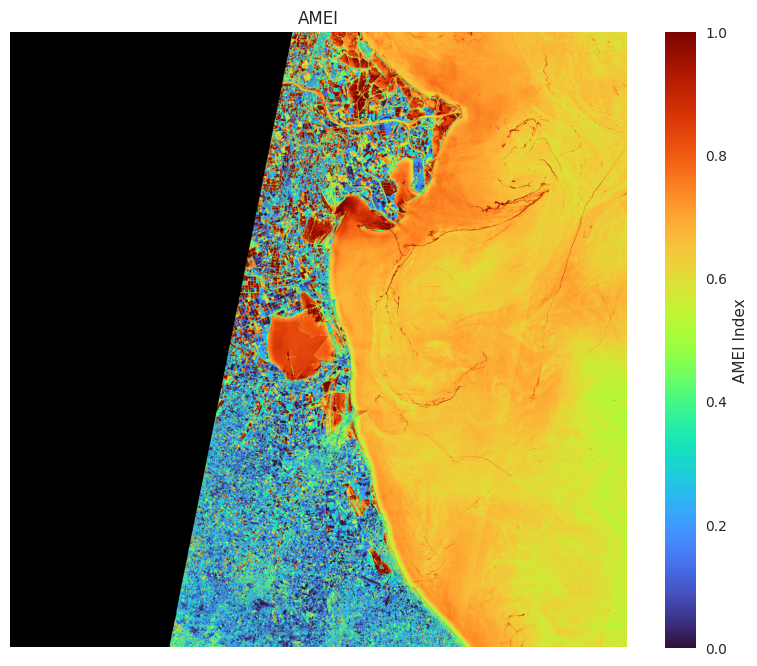

In [4]:
example_file = zarr_files[0]
ds = open_s2_zarr(example_file)

amei = compute_amei(ds)
p2, p98 = np.nanpercentile(amei, (2, 98))
amei = np.clip((amei - p2) / (p98 - p2), 0, 1)

cmap = plt.cm.turbo
cmap.set_bad(color='black')  # NaNs shown as black
plt.figure(figsize=(10,8))
plt.imshow(amei, cmap=cmap)
plt.colorbar(label='AMEI Index')
plt.title("AMEI")
plt.axis('off')
plt.show()

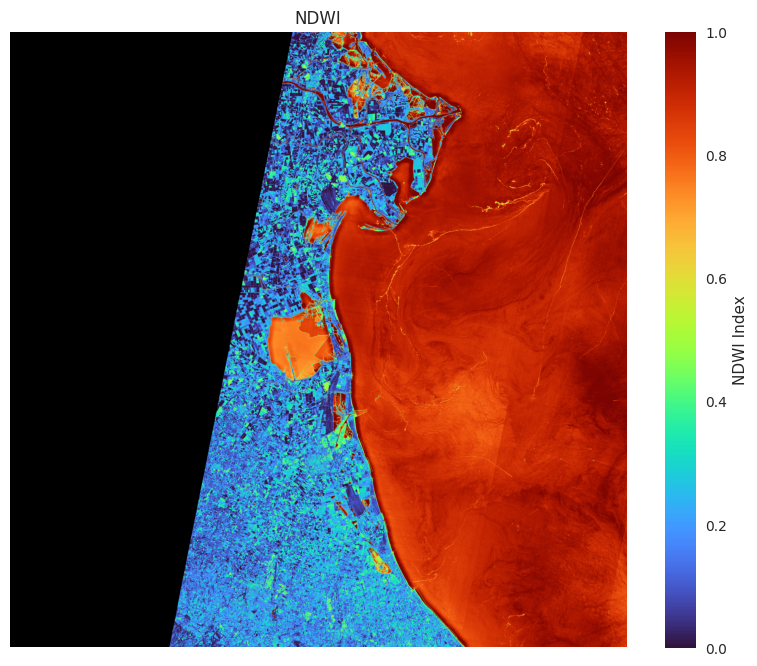

In [26]:
example_file = zarr_files[0]
ds = open_s2_zarr(example_file)

ndwi = compute_ndwi(ds)
p2, p98 = np.nanpercentile(ndwi, (2, 98))
ndwi = np.clip((ndwi - p2) / (p98 - p2), 0, 1)

cmap = plt.cm.turbo
cmap.set_bad(color='black')  # NaNs shown as black
plt.figure(figsize=(10,8))
plt.imshow(ndwi, cmap=cmap)
plt.colorbar(label='NDWI Index')
plt.title("NDWI")
plt.axis('off')
plt.show()

In [ ]:
TILE_ID = "T32TQR"  # Change to the tile you want to animate
OUTPUT_GIF = f"/home/ubuntu/mucilage_pipeline/mucilage-detection/plots/tile_animation_{TILE_ID}.gif"

# Get files for that tile, sorted by date in filename
zarr_files = [f for f in glob.glob(os.path.join(DATA_DIR, "*.zarr")) if TILE_ID in f]
zarr_files = sorted(
    zarr_files,
    key=lambda f: datetime.strptime(os.path.basename(f).split("_")[2][:8], "%Y%m%d")
)

# Prepare figure
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(np.zeros((100, 100, 3)), animated=True)
title = ax.set_title("", fontsize=14)
ax.axis("off")

def update(frame):
    zf = zarr_files[frame]
    ds = open_s2_zarr(zf)
    rgb = get_rgb_from_zarr(ds)
    im.set_array(rgb)
    date_str = os.path.basename(zf).split("_")[2][:8]  # Extract YYYYMMDD
    title.set_text(f"{TILE_ID} - {date_str}")
    return im, title

# Create animation
ani = FuncAnimation(fig, update, frames=len(zarr_files), blit=False, interval=800)

# Save as GIF
ani.save(OUTPUT_GIF, writer=PillowWriter(fps=1))
plt.close(fig)

print(f"Saved animation to {OUTPUT_GIF}")

Saved animation to tile_animation_T32TQR.gif
